In [1]:
import numpy as np
import nltk
from nltk.stem.porter import *
stemmer = PorterStemmer()
from collections import Counter
import emoji
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from pandas.core.frame import DataFrame
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from keras.preprocessing.text import Tokenizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import time
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
def get_covid_Data():
    covid_ids = open("data/covid.data.new.txt", "r")
    covid_data = []
    for covid_ids_str in covid_ids.readlines():
        covid_ids_list = covid_ids_str.strip().split(",")
        temp_json_list = []
        if not os.path.exists("data/covid_object/" + covid_ids_list[0] + ".json"):
            continue
        for covid_id in covid_ids_list:
            covid_path = "data/covid_object/" + covid_id + ".json"
            if os.path.exists(covid_path):
                temp_json_list.append(json.load(open(covid_path, "r")))
        # sort according to time
        temp_json_list = sorted(temp_json_list, key=lambda x: time.mktime(time.strptime(x["created_at"], "%a %b %d %H:%M:%S +0000 %Y")))
        covid_data.append(temp_json_list)
    return np.array(covid_data)

In [3]:
covid_labels = pd.read_csv("data/covid_label_bertweet.csv")

In [4]:
covid_data = get_covid_Data()

C:\Users\pc\AppData\Local\Temp\ipykernel_32552\2522791628.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(covid_data)


In [6]:
rumour_retweet_texts = []
non_rumour_retweet_texts = []
rumour_retweet_event_texts = []
non_rumour_retweet_event_texts = []
rumour_hashtags = []
non_rumour_hashtags = []
non_rumour_no = 0
rumour_no = 0

for i in range(len(covid_labels)):
    retweet_event_text = []
    if covid_labels["Predicted"][i] == 1:
        if len(covid_data[i]) == 1:
            continue
        else: 
            for j in range(1, len(covid_data[i])):
                retweet_event_text.append(covid_data[i][j]["text"])
                rumour_retweet_texts.append(covid_data[i][j]["text"])
                if len(covid_data[i][j]["entities"]["hashtags"]) != 0:
                    for hashtag in covid_data[i][j]["entities"]["hashtags"]:
                        rumour_hashtags.append(hashtag["text"])
            rumour_retweet_event_texts.append(" ".join(retweet_event_text))
    else:
        if len(covid_data[i]) == 1:
            continue
        else:
            for j in range(1, len(covid_data[i])):
                retweet_event_text.append(covid_data[i][j]["text"])
                non_rumour_retweet_texts.append(covid_data[i][j]["text"])
                if len(covid_data[i][j]["entities"]["hashtags"]) != 0:
                    for hashtag in covid_data[i][j]["entities"]["hashtags"]:
                        non_rumour_hashtags.append(hashtag["text"])
            non_rumour_retweet_event_texts.append(" ".join(retweet_event_text))

In [22]:
rumour_hashtags_lower = [w.lower() for w in rumour_hashtags]
non_rumour_hashtags_lower = [w.lower() for w in non_rumour_hashtags]
print(Counter(rumour_hashtags_lower).most_common(20))
print(Counter(non_rumour_hashtags_lower).most_common(30))

[('covid19', 2492), ('coronavirus', 1570), ('trump', 327), ('wuhanvirus', 192), ('coronaviruspandemic', 94), ('trumpvirus', 85), ('dopeydon', 70), ('maga', 67), ('china', 57), ('usa', 56), ('covidiots', 51), ('gop', 50), ('covid', 49), ('covid_19', 49), ('donaldtrump', 48), ('covidー19', 47), ('chinesevirus', 43), ('pandemic', 41), ('chinavirus', 39), ('foxnews', 34)]
[('covid19', 6393), ('coronavirus', 3414), ('wuhanvirus', 358), ('trump', 252), ('china', 183), ('covid_19', 174), ('coronaviruspandemic', 153), ('contest', 134), ('covidー19', 119), ('covid', 113), ('pandemic', 98), ('stayhomestaysafe', 94), ('who', 92), ('covidiots', 91), ('contestalert', 81), ('precautions', 80), ('tmobiletuesdays', 79), ('trumpvirus', 78), ('chinesevirus', 77), ('usa', 77), ('thetrumpvirus', 76), ('lockdown', 73), ('itelsaysstaysafe', 72), ('covid2019', 69), ('stayhome', 68), ('maga', 67), ('ccp', 66), ('coronavirusoutbreak', 62), ('indiafightscorona', 62), ('diamondplaza', 61)]


In [8]:
def cleanData(data):
    data['text'] = data['text'].apply(lambda x: re.sub(r'@\S+', ' ', x))
    data['text'] = data['text'].apply(lambda x: emoji.replace_emoji(x, ' '))
    data['text'] = data['text'].apply(lambda x: re.sub(r'https?://\S+', ' ', x))
    data['text'] = data['text'].apply(lambda x: re.sub(r'http?://\S+', ' ', x))
    data['text'] = data['text'].apply(lambda x: re.sub(r'[0-9]+\.', ' ', x))
    data['text'] = data['text'].apply(lambda x: re.sub(r'[^A-Za-z#]+', ' ', x))
    tokens = data['text'].apply(lambda x: x.split())
    tokens = tokens.apply(lambda x: [str(i).lower() for i in x])
    tokens = tokens.apply(lambda x: [i for i in x if i not in stop_words])
    #tokens = tokens.apply(lambda x: [stemmer.stem(i) for i in x])
    data['text']  = tokens.apply(lambda x: ' '.join(x))

In [9]:
rumour_retweet = DataFrame({'text':rumour_retweet_event_texts})
non_rumour_retweet = DataFrame({'text':non_rumour_retweet_event_texts})
cleanData(rumour_retweet)
cleanData(non_rumour_retweet)

In [11]:
all_rumours = ""
all_non_rumours = ""
for tweet in rumour_retweet["text"].values:
  all_rumours = all_rumours + " " + tweet
for tweet in non_rumour_retweet["text"].values:
  all_non_rumours = all_non_rumours + " " + tweet

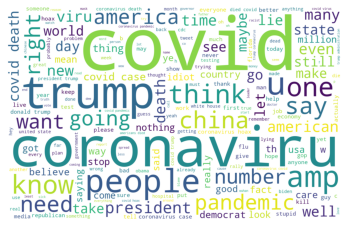

In [12]:
wordcloud = WordCloud(
        background_color="white",
        width=1500,             
        height=960,              
        margin=10              
        ).generate(all_rumours)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

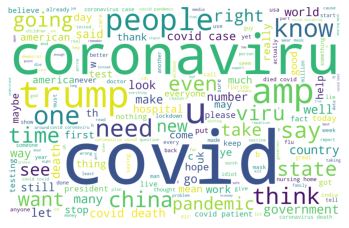

In [13]:
wordcloud = WordCloud(
        background_color="white",
        width=1500,             
        height=960,              
        margin=10              
        ).generate(all_non_rumours)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [14]:
analyzer = SentimentIntensityAnalyzer()

rumour_compound = []
rumour_neg = []
rumour_neu = []
rumour_pos = []
for i in range(len(rumour_retweet)):
  res = analyzer.polarity_scores(rumour_retweet['text'][i])
  rumour_compound.append(res['compound'])
  rumour_neg.append(res['neg'])
  rumour_neu.append(res['neu'])
  rumour_pos.append(res['pos'])

rumour_sentiment = DataFrame({'compound':rumour_compound, 'neg':rumour_neg, 'neu':rumour_neu, 'pos':rumour_pos})
rumour_sentiment.head()

,compound,neg,neu,pos
0,-0.9751,0.310,0.466,0.224
1,-0.5574,0.419,0.581,0.000
2,-0.8036,0.226,0.620,0.153
3,-0.9876,0.219,0.667,0.115
4,-0.9349,0.181,0.677,0.142


In [20]:
rumour_sentiment.describe()

,compound,neg,neu,pos
count,2863.000000,2863.000000,2863.000000,2863.000000
mean,-0.319718,0.200863,0.655123,0.142613
std,0.651406,0.125346,0.139134,0.105677
min,-1.000000,0.000000,0.000000,0.000000
25%,-0.926000,0.127000,0.582000,0.079000
50%,-0.542300,0.201000,0.648000,0.134000
75%,0.226300,0.268000,0.718000,0.194000
max,0.999900,1.000000,1.000000,0.758000


In [15]:
non_rumour_compound = []
non_rumour_neg = []
non_rumour_neu = []
non_rumour_pos = []
for i in range(len(non_rumour_retweet)):
  res = analyzer.polarity_scores(non_rumour_retweet['text'][i])
  non_rumour_compound.append(res['compound'])
  non_rumour_neg.append(res['neg'])
  non_rumour_neu.append(res['neu'])
  non_rumour_pos.append(res['pos'])

non_rumour_sentiment = DataFrame({'compound':non_rumour_compound, 'neg':non_rumour_neg, 'neu':non_rumour_neu, 'pos':non_rumour_pos})
non_rumour_sentiment.head()

,compound,neg,neu,pos
0,-0.2500,0.283,0.507,0.210
1,-0.5168,0.221,0.605,0.174
2,0.9535,0.066,0.521,0.412
3,-0.3182,0.315,0.685,0.000
4,0.6378,0.185,0.602,0.212


In [21]:
non_rumour_sentiment.describe()

,compound,neg,neu,pos
count,9007.000000,9007.000000,9007.000000,9007.000000
mean,-0.073289,0.156845,0.681545,0.155391
std,0.644005,0.134175,0.169842,0.135431
min,-1.000000,0.000000,0.000000,0.000000
25%,-0.695250,0.000000,0.589000,0.051000
50%,0.000000,0.150000,0.674000,0.141000
75%,0.505800,0.234000,0.771000,0.221000
max,1.000000,1.000000,1.000000,1.000000


In [16]:
rumour_vectorizer = TfidfVectorizer()
rumour_tfidf = rumour_vectorizer.fit_transform(rumour_retweet['text'])
rumour_model = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5).fit(rumour_tfidf)
tfidf_feature_names = rumour_vectorizer.get_feature_names()

for topic_idx, topic in enumerate(rumour_model.components_):
    print("Topic #" + str(topic_idx+1) + ":")
    print(", ".join([tfidf_feature_names[i]
                     for i in topic.argsort()[:-10 - 1:-1]]))

C:\Users\pc\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\pc\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic #1:
covid, people, coronavirus, get, like, one, many, cases, amp, going
Topic #2:
coronavirus, hoax, get, like, wuhan, go, would, people, pence, flu
Topic #3:
trump, coronavirus, president, pandemic, response, americans, hoax, donald, us, amp
Topic #4:
china, wuhan, chinese, virus, wuhanvirus, racist, world, ccp, lab, originated
Topic #5:
deaths, death, cases, florida, us, number, new, million, numbers, flu


C:\Users\pc\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
non_rumour_vectorizer = TfidfVectorizer()
non_rumour_tfidf = non_rumour_vectorizer.fit_transform(non_rumour_retweet['text'])
non_rumour_model = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5).fit(non_rumour_tfidf)
tfidf_feature_names = non_rumour_vectorizer.get_feature_names()

for topic_idx, topic in enumerate(non_rumour_model.components_):
    print("Topic #" + str(topic_idx+1) + ":")
    print(", ".join([tfidf_feature_names[i]
                     for i in topic.argsort()[:-10 - 1:-1]]))

C:\Users\pc\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\pc\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic #1:
covid, people, get, amp, like, one, know, mask, many, would
Topic #2:
coronavirus, china, wuhan, people, virus, get, world, like, one, chinese
Topic #3:
trump, president, americans, america, donald, us, administration, response, pence, testing
Topic #4:
deaths, cases, new, death, number, reported, florida, numbers, per, total
Topic #5:
quoted, article, tweet, read, tcm, thank, kerri, exist, real, cdc


C:\Users\pc\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
